## 2: Segmentation of Biomedical Images


In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from time import time
import glob
import imageio.v2 as imageio

np.random.seed(0)

### Plotting and training functions

In [2]:
def training_curve_plot(title, train_losses, test_losses, train_accuracy, test_accuracy):
    """ 
    convenience function for plotting train and test loss and accuracy
    """
    lg=13
    md=8
    sm=7
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(title, fontsize=md)
    x = range(1, len(train_losses)+1)
    axs[0].plot(x, train_losses, label=f'Final train loss: {train_losses[-1]:.4f}')
    axs[0].plot(x, test_losses, label=f'Final test loss: {test_losses[-1]:.4f}')
    axs[0].set_title('Losses', fontsize=md)
    axs[0].set_xlabel('Iteration', fontsize=md)
    axs[0].set_ylabel('Loss', fontsize=md)
    axs[0].legend(fontsize=sm)
    axs[0].tick_params(axis='both', labelsize=sm)
    # Optionally use a logarithmic y-scale
    #axs[0].set_yscale('log')
    axs[0].grid(True, which="both", linestyle='--', linewidth=0.5)
    axs[1].plot(x, train_accuracy, label=f'Final train dice: {train_accuracy[-1]:.4f}')
    axs[1].plot(x, test_accuracy, label=f'Final test dice: {test_accuracy[-1]:.4f}')
    axs[1].set_title('dice', fontsize=md)
    axs[1].set_xlabel('Iteration', fontsize=md)
    axs[1].set_ylabel('dice (%)', fontsize=sm)
    axs[1].legend(fontsize=sm)
    axs[1].tick_params(axis='both', labelsize=sm)
    axs[1].grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.show()

In [3]:
def plot_image(title: str, input_im: torch.Tensor, model_mask: torch.Tensor, label_mask: torch.Tensor, dice_score: float):
    """
    Plots 3 images side by side, 
    highlighting difference between 
    ground truth and model output
    Args:
        title: str, title of the plot
        input_im: torch.Tensor, input image
        model_mask: torch.Tensor, model output
        label_mask: torch.Tensor, ground truth
        dice_score: float, dice score
    """
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))
    fig.suptitle(title, fontsize=15)
    axs[0].imshow(input_im[0, 0].detach().numpy(), cmap='gray')
    axs[0].set_title('Input Image')
    axs[1].imshow(model_mask[0, 0].detach().numpy(), cmap='gray')
    axs[1].set_title('Model Mask')
    axs[2].imshow(label_mask[0, 0].detach().numpy(), cmap='gray')
    axs[2].set_title('True Mask')
    plt.show() 

In [4]:
def visualize_mask(
    case: dict[str : torch.Tensor | float | int], name: str
) -> None:
    fontsize = 16
    image = case["input"].detach().permute(1, 2, 0).numpy().astype("uint8")
    mask = case["label"].detach()
    prediction = case["output"].unsqueeze(0).detach().numpy().astype("uint8")
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"{name} - Dice score: {case['performance']:.4f}\n", fontsize=fontsize)

    axes[0].imshow(image)
    axes[0].set_title("Input Image", fontsize=fontsize)
    axes[0].axis("off")

    axes[1].imshow(mask.squeeze(), cmap="gray")
    axes[1].set_title("Ground Truth Mask", fontsize=fontsize)
    axes[1].axis("off")

    axes[2].imshow(prediction.squeeze(), cmap="gray")
    axes[2].set_title("Predicted Mask", fontsize=fontsize)
    axes[2].axis("off")
    plt.tight_layout()
    plt.show()

In [5]:
def dice_coefficient(outputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    """
    Args:
        ouputs: tresholded outputs of the model
        targets: targeted true labels
    Returns:
        dice score
    """
    eps = 1e-8
    intersection = torch.sum(abs(outputs) *abs(targets))
    union = torch.sum(outputs) + torch.sum(targets)
    dice = (2. * intersection) / abs(union + eps)
    return dice

def train_network(model: nn.Module, criteria: nn.Module, 
                  optimizer: torch.optim.Optimizer, num_epochs: int, train_loader: torch.utils.data.DataLoader, 
                  test_loader: torch.utils.data.DataLoader, device: torch.device, model_name: str, lr: float) -> None:
    """
    Train a neural network model
    
    Args:
        model: The neural network model to be trained
        criteria: The loss function
        optimizer: The optimizer
        num_epochs: The number of epochs to train the model
        train_loader: The training data loader
        test_loader: The test data loader
        device: The device to run the model on
    """
    train_losses = []
    test_losses = []
    train_dice_scores = []
    test_dice_scores = []
    start = time()
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_dice = 0

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criteria(outputs, labels)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()

            # Calculate Dice score
            outputs = (outputs > 0.5).float()
            dice = dice_coefficient(outputs, labels)
            train_dice += dice.item()
        
        train_losses.append(train_loss / len(train_loader))
        train_dice_scores.append(train_dice / len(train_loader))
    
        model.eval()
        test_loss = 0
        test_dice = 0

        with torch.no_grad():
            for i, (images, labels) in enumerate(test_loader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criteria(outputs, labels)
                test_loss += loss.item()

                # Calculate Dice score
                outputs = (outputs > 0.5).float()
                dice = dice_coefficient(outputs, labels)
                test_dice += dice.item()
            
            test_losses.append(test_loss / len(test_loader))
            test_dice_scores.append(test_dice / len(test_loader))
        if (epoch+1)%10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Train Dice Score: {train_dice_scores[-1]:.4f}, Test Dice Score: {test_dice_scores[-1]:.4f}')
    total = time() - start
    plot_title = model_name + " - lr: " + str(lr) + " - Total Time: " + str(total // 60) + "min " + str(total % 60) + "s " + "-Epochs: " + str(num_epochs)
    return plot_title, train_losses, test_losses, train_dice_scores, test_dice_scores

In [6]:
def find_best_worst(
    model: torch.nn.Module,
    X_test: torch.Tensor,
    Y_test: torch.Tensor,
    device: torch.device,
) -> tuple[
    dict[str, torch.Tensor | float | int], dict[str, torch.Tensor | float | int]
]:
    """Find the best and worst performance of the model in terms of dice-score.

    Args:
        model (torch.nn.Module): Model to evaluate
        X_test: Test images
        Y_test: Test labels
        device: Device to run the model on

    Returns:
        Two dictionaries containing the best and worst case
    """
    best = {
        "input": None,
        "label": None,
        "output": None,
        "performance": float("-inf"),
        "index": None,
    }
    worst = {
        "input": None,
        "label": None,
        "output": None,
        "performance": float("inf"),
        "index": None,
    }
    with torch.no_grad():
        for index, (inputs, labels) in enumerate(zip(X_test, Y_test)):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            outputs = (outputs > 0.5).float()

            performance = dice_coefficient(outputs, labels)

            if performance > best["performance"]:
                best["input"] = inputs
                best["label"] = labels
                best["output"] = outputs
                best["performance"] = performance
                best["index"] = index

            if performance < worst["performance"]:
                worst["input"] = inputs
                worst["label"] = labels
                worst["output"] = outputs
                worst["performance"] = performance
                worst["index"] = index
    return best, worst

### Loading of Warwick dataset

In [7]:

def load_warwick():

  train_images = []
  train_labels = []
  test_images = []
  test_labels = []

  for image_path in sorted(glob.glob("WARWICK/WARWICK" + "/Train/image_*.png")):
    image = imageio.imread(image_path)
    train_images.append(image)
  for label_path in sorted(glob.glob("WARWICK/WARWICK" + "/Train/label_*.png")):
    label = imageio.imread(label_path)
    train_labels.append(label)  

  for image_path in sorted(glob.glob("WARWICK/WARWICK" + "/Test/image_*.png")):
    image = imageio.imread(image_path)
    test_images.append(image)
  for label_path in sorted(glob.glob("WARWICK/WARWICK" + "/Test/label_*.png")):
    label = imageio.imread(label_path)
    test_labels.append(label)

  X_train = torch.tensor(np.array(train_images), dtype=torch.float, requires_grad=True).permute(0,3,1,2)
  Y_train = torch.tensor(np.array(train_labels), dtype=torch.long)/255
  X_test = torch.tensor(np.array(test_images), dtype=torch.float, requires_grad=True).permute(0,3,1,2)
  Y_test = torch.tensor(np.array(test_labels), dtype=torch.long)/255

  return X_train, Y_train, X_test, Y_test
     


In [8]:
bz = 8
X_train, Y_train, X_test, Y_test = load_warwick()
# create dataloader
train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bz, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=bz, shuffle=False)

### Models (i = CNN from last exercise, ii = variant of Unet (no residual connections))

In [9]:
class convnetrefurbed(nn.Module):
    def __init__(self):
        super(convnetrefurbed, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, 1, 1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(8, 16, 3, 1, 1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(16, 32, 3, 1, 1)
        self.relu3 = nn.ReLU()

        self.up1 = nn.ConvTranspose2d(32, 16, 2, 2)
        self.relu4 = nn.ReLU()
        
        self.conv4 = nn.Conv2d(16, 1, 3, 1, 1)
        self.up2 = nn.ConvTranspose2d(1, 1, 2, 2)
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.relu3(x)

        x = self.up1(x)
        x = self.relu4(x)

        x = self.conv4(x)
        x = self.up2(x)
        return x.squeeze()

        

In [10]:


# Define the modified CNN architecture
class UNet_Variant(nn.Module):
    def init_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                    nn.init.xavier_uniform_(m.weight)

    def __init__(self):
        


        super(UNet_Variant, self).__init__()
        # Initialize the layers for 3x128x128 input
        self.conv1 = nn.Conv2d(3, 3, 1, 1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(3, 3, 1, 1)
      
        # Max pool and downsampling
        self.pool = nn.MaxPool2d(2, 2)
        # Initialize the layers for 3x64x64 input
        self.conv3 = nn.Conv2d(3, 3, 1, 1)
        self.relu2 = nn.ReLU()
        self.conv4 = nn.Conv2d(3, 3, 1, 1)
        
        # Max pool and downsampling
        self.pool1 = nn.MaxPool2d(2, 2)
        # Initialize the layers for 3x32x32 input
        self.conv5 = nn.Conv2d(3, 3, 1, 1)
        self.relu3 = nn.ReLU()
        self.conv6 = nn.Conv2d(3, 3, 1, 1)
        # Max pool and downsampling
        self.pool2 = nn.MaxPool2d(2, 2)
        # Initialize the layers for 3x16x16 input
        self.conv7 = nn.Conv2d(3, 3, 1, 1)
        self.relu4 = nn.ReLU()
        self.conv8 = nn.Conv2d(3, 3, 1, 1)
        
        # Upsampling and deconvolution using transposed convolution
        self.up1 = nn.ConvTranspose2d(3, 3, 2, 2)
        # Initialize the layers for 3x32x32 input
        self.conv9 = nn.Conv2d(3, 3, 1, 1)
        self.relu5 = nn.ReLU()
        self.conv10 = nn.Conv2d(3, 3, 1, 1)
        # Upsampling and deconvolution using transposed convolution
        self.up2 = nn.ConvTranspose2d(3, 3, 2, 2)
        # Initialize the layers for 3x64x64 input
        self.conv11 = nn.Conv2d(3, 3, 1, 1)
        self.relu6 = nn.ReLU()
        self.conv12 = nn.Conv2d(3, 3, 1, 1)
        # Upsampling and deconvolution using transposed convolution
        self.up3 = nn.ConvTranspose2d(3, 3, 2, 2)
        # Initialize the layers for 1x128x128 input
        self.conv13 = nn.Conv2d(3, 3, 1, 1)
        self.relu7 = nn.ReLU()
        self.conv14 = nn.Conv2d(3, 1, 1, 1)

        #self.init_weights()

    

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.relu2(x)
        x = self.conv4(x)
        x = self.pool1(x)
        x = self.conv5(x)
        x = self.relu3(x)
        x = self.conv6(x)
        x = self.pool2(x)
        x = self.conv7(x)
        x = self.relu4(x)
        x = self.conv8(x)
        x = self.up1(x)
        x = self.conv9(x)
        x = self.relu5(x)
        x = self.conv10(x)
        x = self.up2(x)
        x = self.conv11(x)
        x = self.relu6(x)
        x = self.conv12(x)
        x = self.up3(x)
        x = self.conv13(x)
        x = self.relu7(x)
        x = self.conv14(x)

        return x.squeeze()



In [11]:
# Hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 250
learning_rate = 0.001   
criterion = nn.BCEWithLogitsLoss()
model = convnetrefurbed().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [12]:
nets = {}


In [13]:
nets["cnet"] = train_network(model, criterion, optimizer, num_epochs=num_epochs,train_loader=train_loader, test_loader=test_loader,  device=device, model_name='Modified CNN', lr=learning_rate)

Epoch 10/250, Train Loss: 0.6437, Test Loss: 0.6561, Train Dice Score: 0.5390, Test Dice Score: 0.4723
Epoch 20/250, Train Loss: 0.5722, Test Loss: 0.5997, Train Dice Score: 0.5733, Test Dice Score: 0.5716
Epoch 30/250, Train Loss: 0.4813, Test Loss: 0.5417, Train Dice Score: 0.7364, Test Dice Score: 0.6809
Epoch 40/250, Train Loss: 0.4423, Test Loss: 0.5289, Train Dice Score: 0.7779, Test Dice Score: 0.7433
Epoch 50/250, Train Loss: 0.4099, Test Loss: 0.5245, Train Dice Score: 0.7942, Test Dice Score: 0.7842
Epoch 60/250, Train Loss: 0.4164, Test Loss: 0.4990, Train Dice Score: 0.7855, Test Dice Score: 0.6816
Epoch 70/250, Train Loss: 0.3757, Test Loss: 0.5605, Train Dice Score: 0.8148, Test Dice Score: 0.7984
Epoch 80/250, Train Loss: 0.3799, Test Loss: 0.4553, Train Dice Score: 0.8230, Test Dice Score: 0.7387
Epoch 90/250, Train Loss: 0.3579, Test Loss: 0.4736, Train Dice Score: 0.8264, Test Dice Score: 0.7917
Epoch 100/250, Train Loss: 0.3429, Test Loss: 0.4877, Train Dice Score: 0

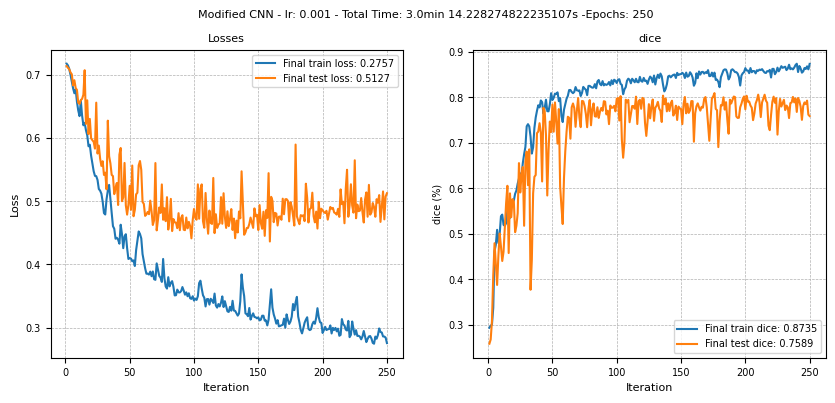

In [14]:
# Plot the loss and dice score
training_curve_plot(*nets["cnet"])

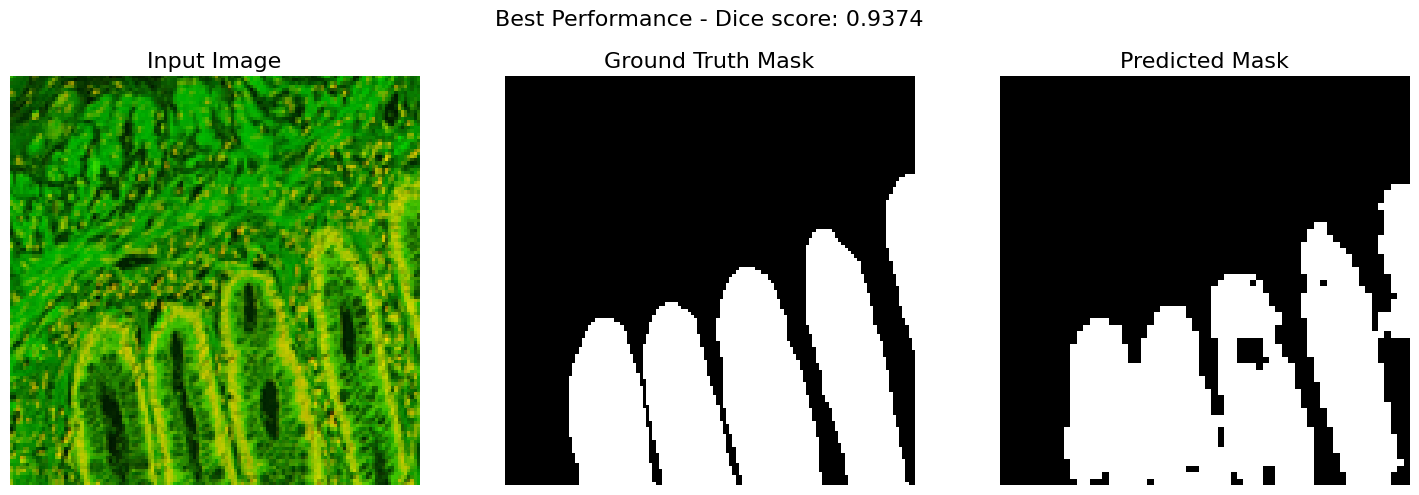

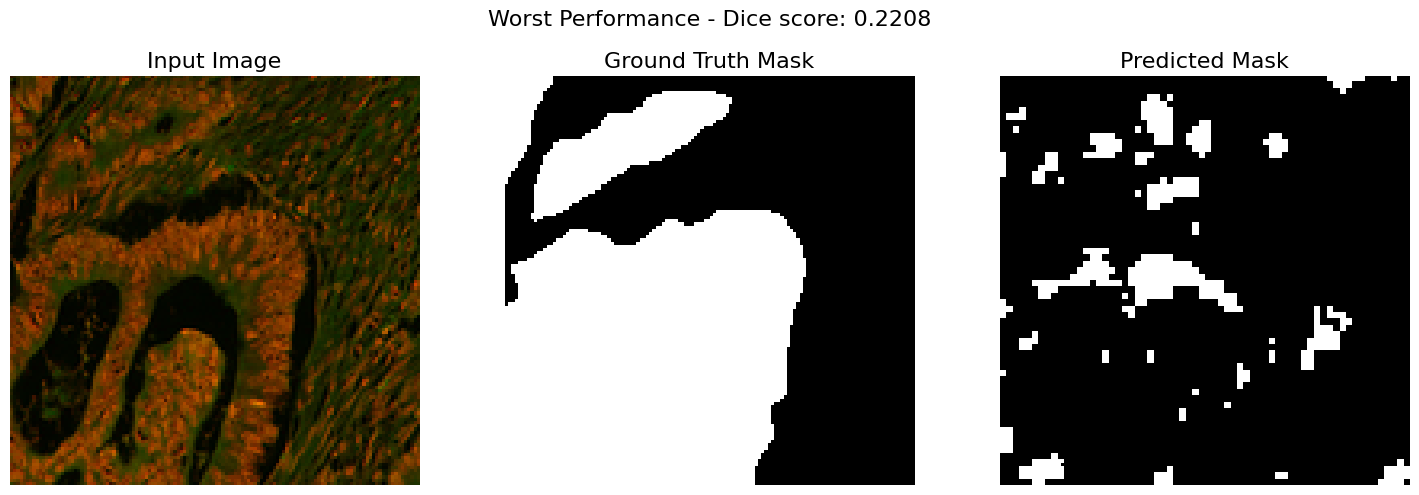

In [15]:
# Show best and worst performance
best, worst = find_best_worst(model, X_test, Y_test, device)
visualize_mask(best, "Best Performance")

visualize_mask(worst, "Worst Performance")

#### Variant i) Dropout layer after max pooling

In [31]:
class cnndrop(nn.Module):
    def __init__(self):
        super(cnndrop, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, 1, 1)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.2)
        self.maxpool1 = nn.MaxPool2d(2, 2)
        

        self.conv2 = nn.Conv2d(8, 16, 3, 1, 1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(2, 2)
        
        
        self.conv3 = nn.Conv2d(16, 32, 3, 1, 1)
        self.relu3 = nn.ReLU()

        self.up1 = nn.ConvTranspose2d(32, 16, 2, 2)
        self.relu4 = nn.ReLU()
        
        self.conv4 = nn.Conv2d(16, 1, 3, 1, 1)
        self.up2 = nn.ConvTranspose2d(1, 1, 2, 2)
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.drop1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        
        x = self.conv3(x)
        x = self.relu3(x)

        x = self.up1(x)
        x = self.relu4(x)

        x = self.conv4(x)
        #x = self.drop2(x)
        x = self.up2(x)
        return x.squeeze()

In [36]:
num_epochs = 250
learning_rate = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modeli = cnndrop().to(device)
optimizer = torch.optim.Adam(modeli.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()


In [37]:
nets["cnn_drop"] = train_network(modeli, criterion, optimizer, num_epochs=num_epochs, train_loader=train_loader, test_loader=test_loader, device=device, model_name="CNN w dropout", lr=learning_rate)

Epoch 10/250, Train Loss: 0.5889, Test Loss: 0.6524, Train Dice Score: 0.5585, Test Dice Score: 0.5860
Epoch 20/250, Train Loss: 0.4919, Test Loss: 0.5414, Train Dice Score: 0.7035, Test Dice Score: 0.6288
Epoch 30/250, Train Loss: 0.4661, Test Loss: 0.5422, Train Dice Score: 0.7423, Test Dice Score: 0.7453
Epoch 40/250, Train Loss: 0.4257, Test Loss: 0.4672, Train Dice Score: 0.7801, Test Dice Score: 0.7127
Epoch 50/250, Train Loss: 0.4083, Test Loss: 0.4524, Train Dice Score: 0.7954, Test Dice Score: 0.7290
Epoch 60/250, Train Loss: 0.3999, Test Loss: 0.4454, Train Dice Score: 0.7956, Test Dice Score: 0.7329
Epoch 70/250, Train Loss: 0.3779, Test Loss: 0.4343, Train Dice Score: 0.8119, Test Dice Score: 0.7804
Epoch 80/250, Train Loss: 0.3810, Test Loss: 0.4369, Train Dice Score: 0.8047, Test Dice Score: 0.7161
Epoch 90/250, Train Loss: 0.3497, Test Loss: 0.4290, Train Dice Score: 0.8290, Test Dice Score: 0.7507
Epoch 100/250, Train Loss: 0.3460, Test Loss: 0.4168, Train Dice Score: 0

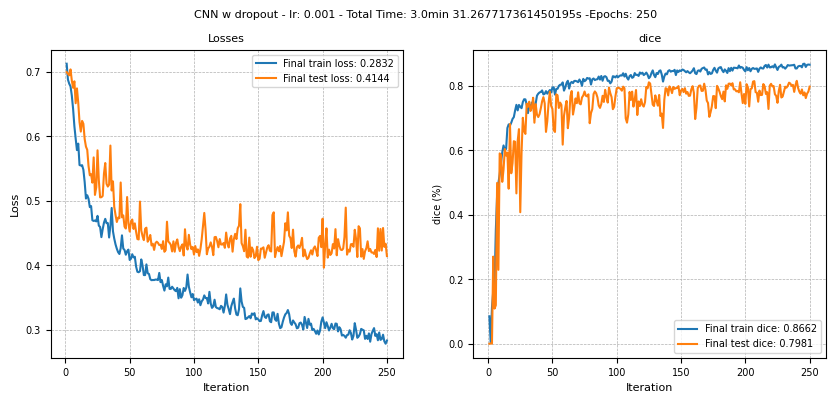

In [42]:
training_curve_plot(*nets["cnn_drop"])

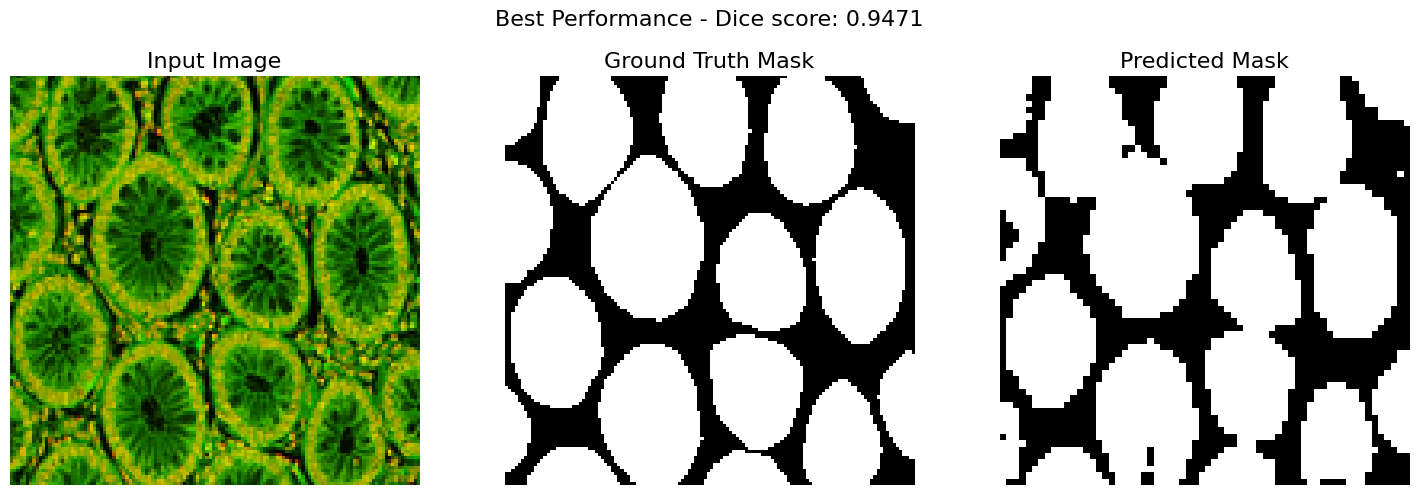

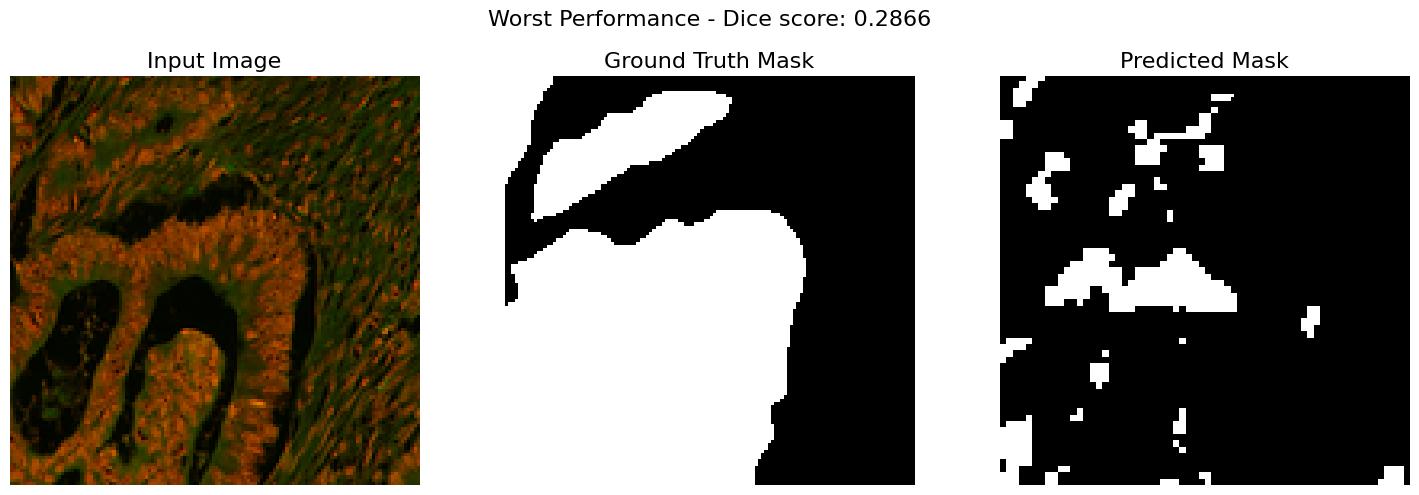

In [39]:
best, worst = find_best_worst(modeli, X_test, Y_test, device)
visualize_mask(best, "Best Performance")

visualize_mask(worst, "Worst Performance")

### Ignore, Tried to implement UNET: DID NOT WORK

In [20]:
#initilize unet model
# Warning, this model sometimes initilizes on a saddle point and gets stuck
num_epochs = 250
learning_rate = 0.01 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelu = UNet_Variant().to(device)
optimizer = torch.optim.Adam(modelu.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(modelu.parameters(), lr=learning_rate, momentum=0.99, nesterov=True)
criterion = nn.BCEWithLogitsLoss()


In [21]:
nets["unet"] = train_network(modelu, criterion, optimizer, num_epochs=num_epochs,train_loader=train_loader, test_loader=test_loader,  device=device, model_name='UNet Variant', lr=learning_rate)

Epoch 10/250, Train Loss: 0.6934, Test Loss: 0.6932, Train Dice Score: 0.0000, Test Dice Score: 0.0000
Epoch 20/250, Train Loss: 0.6276, Test Loss: 0.7295, Train Dice Score: 0.5148, Test Dice Score: 0.5791
Epoch 30/250, Train Loss: 0.5976, Test Loss: 0.6918, Train Dice Score: 0.5594, Test Dice Score: 0.5833
Epoch 40/250, Train Loss: 0.5943, Test Loss: 0.6367, Train Dice Score: 0.5858, Test Dice Score: 0.5062
Epoch 50/250, Train Loss: 0.5807, Test Loss: 0.6656, Train Dice Score: 0.6296, Test Dice Score: 0.6454
Epoch 60/250, Train Loss: 0.5754, Test Loss: 0.6201, Train Dice Score: 0.6246, Test Dice Score: 0.6261
Epoch 70/250, Train Loss: 0.5683, Test Loss: 0.6216, Train Dice Score: 0.6241, Test Dice Score: 0.6546
Epoch 80/250, Train Loss: 0.5785, Test Loss: 0.5982, Train Dice Score: 0.6536, Test Dice Score: 0.5937
Epoch 90/250, Train Loss: 0.5751, Test Loss: 0.6027, Train Dice Score: 0.6393, Test Dice Score: 0.6548
Epoch 100/250, Train Loss: 0.5657, Test Loss: 0.6377, Train Dice Score: 0

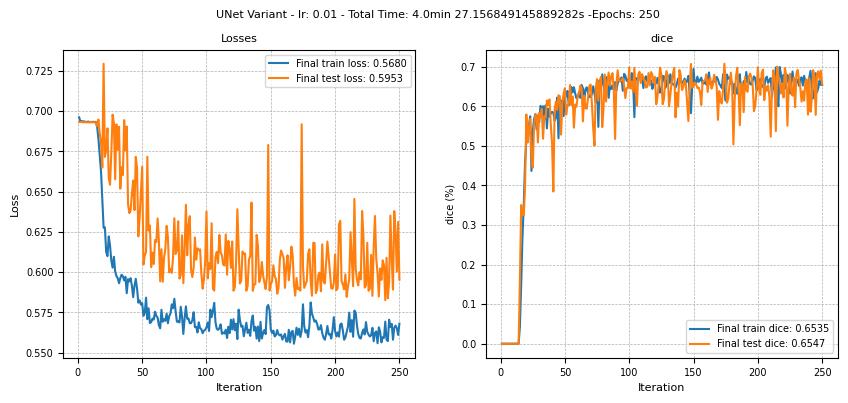

In [22]:
training_curve_plot(*nets["unet"])

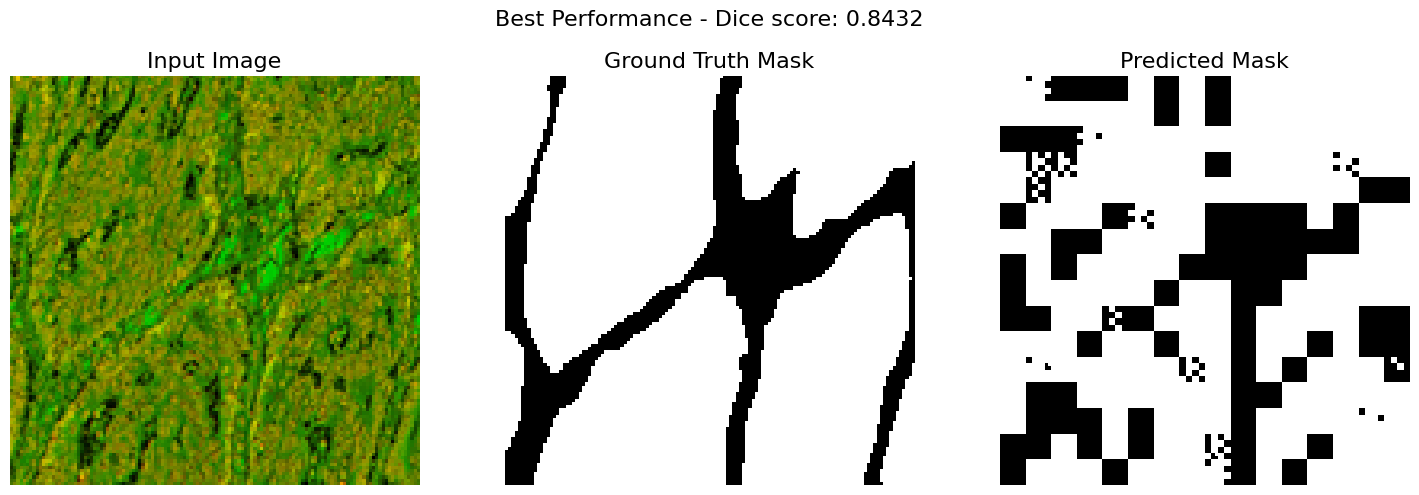

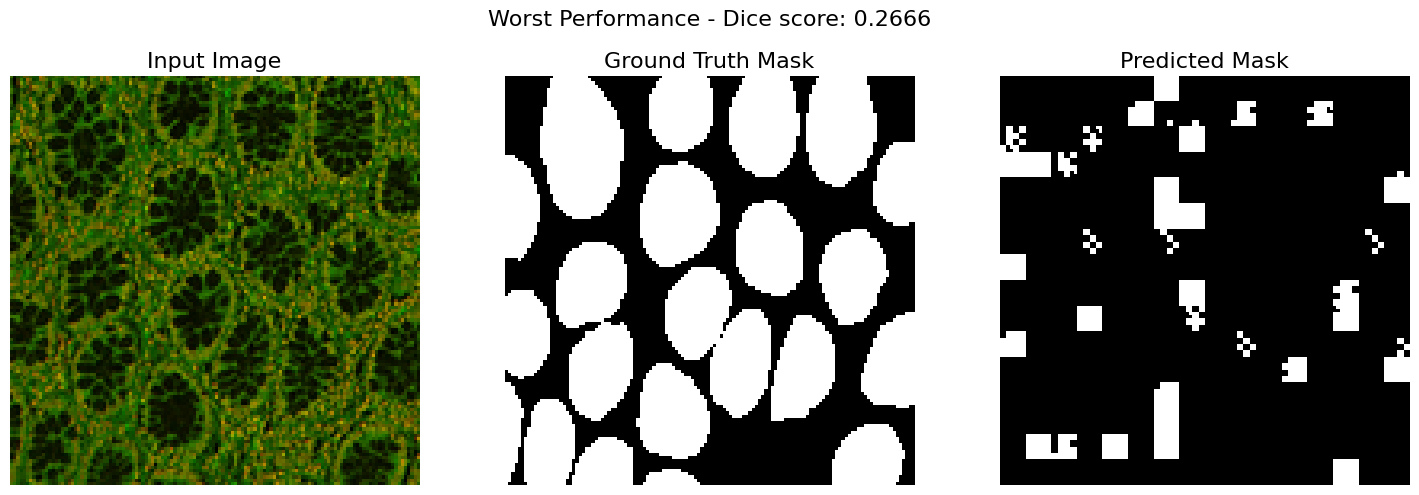

In [25]:
best, worst = find_best_worst(modelu, X_test, Y_test, device)
visualize_mask(best, "Best Performance")

visualize_mask(worst, "Worst Performance")